In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("ggplot")

from datetime import datetime

# c++ EPG implementation (wrapped using Cython) 
import pyepg



## Basic usage

In [2]:
M0 = 1.0
T1 = 800.0
T2 = 50.0
alpha = 40.0
phi = 0.0
TR  = 5.0
ph_inc = 50.

# Create EPG object
EPG = pyepg.PyEPG(M0, T1, T2, TR)

# Output tissue parameters
print("Tissue parameters")
print("=================")
print("M0/T1/T2: %.2f/%.2f/%.2f\n\n" % (EPG.GetM0(), EPG.GetT1(), EPG.GetT2()))

print("Simple example")
print("==============")

# Apply RF pulse (flipangle dAlpha, phase dPhi) and evolve one repetition time TR
EPG.Step(alpha, phi)
steps = EPG.GetStep()
print("Step (# of applied RF pulses): %d" % steps)
print("|Mxy|: %.2f"%EPG.GetMagFa())
print("Mx: %.2f"%EPG.GetReFa())
print("My: %.2f"%EPG.GetImFa())
print("Mz: %.2f\n" % EPG.GetMagZa())

# Apply RF pulse again
EPG.Step(alpha, phi)
steps = EPG.GetStep()
print("Step (# of applied RF pulses): %d" % steps)
print("|Mxy|: %.2f"%EPG.GetMagFa())
print("Mz: %.2f\n" % EPG.GetMagZa())

# Spoil transverse magnetization
EPG.NullTransverse()
print("|Mxy|: %.2f"%EPG.GetMagFa())
print("Mz: %.2f\n" % EPG.GetMagZa())

# Back to equilibrium
EPG.Equilibrium()


steps = EPG.StepsToSS(alpha, ph_inc)
print("Steps to steady state: %d"%steps)

Tissue parameters
M0/T1/T2: 1.00/800.00/50.00


Simple example
Step (# of applied RF pulses): 1
|Mxy|: 0.64
Mx: 0.00
My: -0.64
Mz: 0.77

Step (# of applied RF pulses): 2
|Mxy|: 0.49
Mz: 0.59

|Mxy|: 0.00
Mz: 0.59

Steps to steady state: 61


### Gradient echo 

In [3]:
start_time = datetime.now()
Np = 500
EPG = pyepg.PyEPG()
EPG.SetParameters(1.0, T1, T2, TR)
EPG.Equilibrium()
phi_arr = np.zeros(Np)
flip = np.ones(Np) * alpha
Sig = EPG.GetMagTrain(flip, phi_arr)
        
end_time = datetime.now()
delta = end_time - start_time
print("->EPG calculation was DONE in %.2f milliseconds" % (delta.total_seconds() * 1000))

->EPG calculation was DONE in 2.53 milliseconds


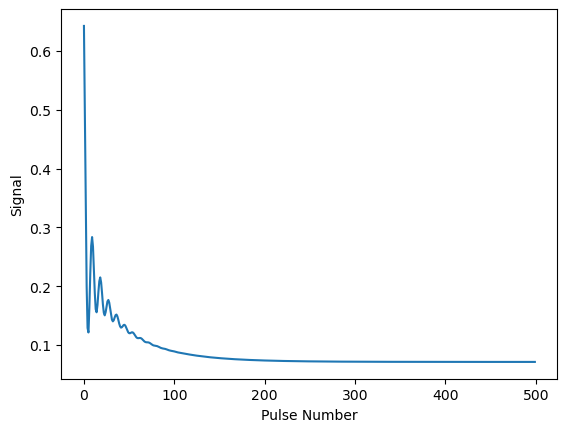

In [4]:
plt.plot(Sig)
plt.xlabel("Pulse Number")
plt.ylabel("Signal")
plt.show()

### Signal Shaping (Gradient echo)

In [5]:
from datetime import datetime
start_time = datetime.now()
Np = 256
Ftarget = np.ones(Np)
EPG.Equilibrium()
FA_arr = EPG.FindFlipAngleTrain(Ftarget, 5.)

end_time = datetime.now()
delta = end_time - start_time
# Call ./epg in build directory for comparison (runs "main.cpp")
# average result takes 13 milliseconds (Macbook Pro i7)
print("->DONE in %.2f milliseconds" % (delta.total_seconds() * 1000))


->DONE in 90.11 milliseconds


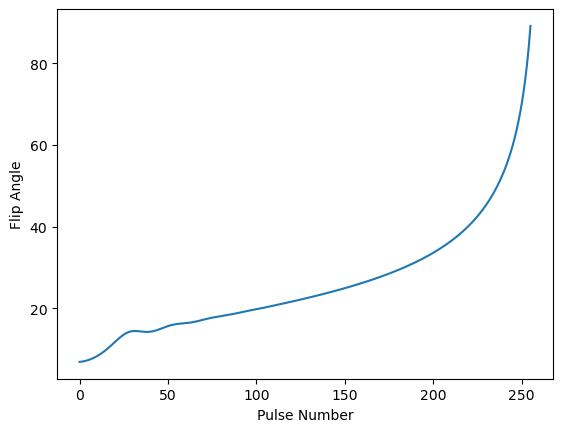

In [6]:
plt.plot(FA_arr)
plt.xlabel("Pulse Number")
plt.ylabel("Flip Angle")
plt.show()

### (unbalanced) SSFP signal with small RF spoiling increments

-> EPG calculation was DONE in 1009.36 milliseconds



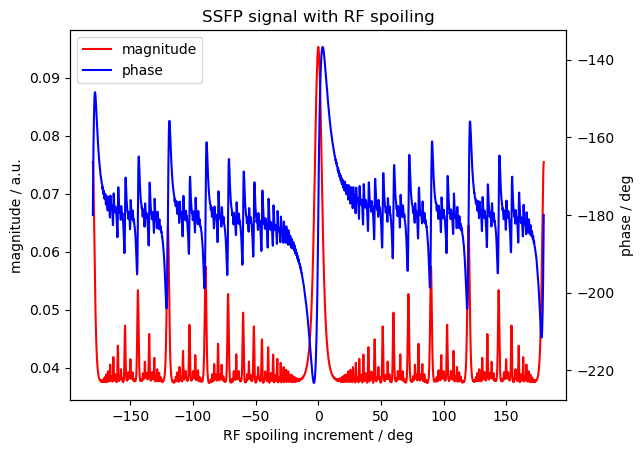

In [7]:
# function to calculate SSFP signal with RF spoiling increment delta_phi
def gre_spoiled_epg(T1, T2, alpha, delta_phi, TR, abs_err_tol = 1e-6 ):
    EPG = pyepg.PyEPG()
    EPG.SetParameters(1.0, T1, T2, TR)
    EPG.Equilibrium()
    EPG.StepsToSS(alpha, delta_phi, abs_err_tol)
    signal = (EPG.GetReFa()+1.0j*EPG.GetImFa())*np.exp(-1.0j*np.deg2rad(EPG.GetPhase()))
    return ( np.abs(signal), np.angle(signal) -np.pi/2 )     

T1        = 1000
T2        = 80
TR        = 8
alpha     = 20
N         = 2000
d_phi     = np.linspace(-180,180,N)
mgn       = np.zeros(N)
phs       = np.zeros(N)

start_time = datetime.now()
for i in range(N):
    mgn[i],phs[i] = gre_spoiled_epg(T1, T2, alpha, d_phi[i], TR, 1e-10)
deltaS = datetime.now() - start_time

print('-> EPG calculation was DONE in %.2f milliseconds\n' % (deltaS.total_seconds() * 1000))


plt.plot(d_phi,mgn,'r')
plt.ylabel('magnitude / a.u.')
plt.xlabel('RF spoiling increment / deg')
plt.title('SSFP signal with RF spoiling')
ax2 = plt.twinx()
ax2.plot([],[],'r',label='magnitude' )
ax2.plot(d_phi,np.rad2deg(phs),'b',label='phase')
ax2.set_ylabel('phase / deg')
plt.legend(loc='upper left')
plt.show()


### Copy Constructor
Sometimes it is useful to keep a copy of an EPG. This can be done with the copy constructor: ```b = pyepg.PyPEG(a)```
See example below:

In [8]:
EPG = pyepg.PyEPG()
EPG.SetParameters(1.0, T1, T2,TR)
EPG.Equilibrium()
ERRTOL = 1e-8
N1 = EPG.StepsToSS(alpha, 50, ERRTOL)       #steps to steady-state from equilibrium with phase-increment 50
EPGcopy = pyepg.PyEPG(EPG)                      #copy of EPG state
N2 = EPGcopy.StepsToSS(alpha, 117, ERRTOL)  #steps to steady-state from previous state with phase-increment 117
EPG.Equilibrium()                               #reset first EPG to equilibrium
N3 = EPG.StepsToSS(alpha, 117, ERRTOL)      #steps to steady-state from equilibrium with phase-increment 117
print("object EPG     - steps to steady-state from equilibrium with phase-increment 50     :   N1 =",N1)
print("object EPGcopy - steps to steady-state from previous state with phase-increment 117 :   N2 =",N2)
print("object EPG     - steps to steady-state from equilibrium with phase-increment 117    :   N3 =",N3)
print("object EPG     - number of states = N3+1          = ",EPG.GetStep())
print("object EPGcopy - number of states = (N1+1)+(N2+1) = ",EPGcopy.GetStep())


object EPG     - steps to steady-state from equilibrium with phase-increment 50     :   N1 = 197
object EPGcopy - steps to steady-state from previous state with phase-increment 117 :   N2 = 161
object EPG     - steps to steady-state from equilibrium with phase-increment 117    :   N3 = 202
object EPG     - number of states = N3+1          =  203
object EPGcopy - number of states = (N1+1)+(N2+1) =  360
